In [1]:
from Indexed_Dataset import *
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import random
from torch.utils.data import WeightedRandomSampler

In [2]:
torch.manual_seed(42)
np.random.seed(42)
# torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

In [3]:
train_arr = np.loadtxt("../data/embed_trainvf.csv", dtype=np.float32, delimiter=",", skiprows=1)
mean = train_arr[:, -1].mean()
std = train_arr[:, -1].std()
train_arr = train_arr[train_arr[:, -1] < mean + 5 * std]
train_arr = train_arr[train_arr[:, -1] > 50]

In [4]:
# Split into training/validation sets
np.random.shuffle(train_arr)
valid_arr = train_arr[int(0.9 * train_arr.shape[0]):]
train_arr = train_arr[:int(0.9 * train_arr.shape[0])]
weights = train_arr[:, -1]

In [5]:
sampler = WeightedRandomSampler(weights=weights, num_samples=train_arr.shape[0], replacement=True)

train_set = Indexed_Dataset(arr=train_arr)
train_load = DataLoader(dataset=train_set,
                        batch_size=32,
#                         sampler=sampler,
                        shuffle=True,
                        num_workers=8,
                        worker_init_fn=seed_worker,
                        generator=g,)

valid_set = Indexed_Dataset(arr=valid_arr)
valid_load = DataLoader(dataset=valid_set,
                        batch_size=32,
                        # num_workers=8,
                        shuffle=True,
                        worker_init_fn=seed_worker,
                        generator=g,)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
class TravelRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        origin_call_dim = 6
        origin_stand_dim = 5
        taxi_id_dim = 5
        year_dim = 2
        wk_of_yr_dim = 5
        wk_day_dim = 5
        hr_dim = 5
        
        self.embed_origin_call: nn.Module = nn.Embedding(29027, origin_call_dim)
        self.embed_origin_stand: nn.Module = nn.Embedding(64, origin_stand_dim)
        self.embed_taxi_id: nn.Module = nn.Embedding(448, taxi_id_dim)
        self.embed_year: nn.Module = nn.Embedding(2, year_dim)
        self.embed_wk_of_yr: nn.Module = nn.Embedding(52, wk_of_yr_dim)
        self.embed_wk_day: nn.Module = nn.Embedding(7, wk_day_dim)
        self.embed_hr: nn.Module = nn.Embedding(24, hr_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(6 + 
                      origin_call_dim + 
                      origin_stand_dim + 
                      taxi_id_dim + 
                      year_dim + 
                      wk_of_yr_dim +
                      wk_day_dim + 
                      hr_dim
                      ,1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 1)
        )

    def forward(self, input: torch.Tensor):
        origin_call = self.embed_origin_call(input[:, 0].to(dtype=torch.int32))
        origin_stand = self.embed_origin_stand(input[:, 1].to(dtype=torch.int32))
        taxi_id = self.embed_taxi_id(input[:, 2].to(dtype=torch.int32))
        year = self.embed_year(input[:, 8].to(dtype=torch.int32))
        wk_of_year = self.embed_wk_of_yr(input[:, 9].to(dtype=torch.int32))
        wk_day = self.embed_wk_day(input[:, 10].to(dtype=torch.int32))
        hr = self.embed_hr(input[:, 11].to(dtype=torch.int32))
        input = torch.cat((origin_call, 
                           origin_stand, 
                           taxi_id, 
                           input[:, 3:8],
                           year,
                           wk_of_year,
                           wk_day,
                           hr,
                           input[:, 12:]
                           ), dim=1).to(dtype=torch.float32)
        input = self.feed_forward(input.to(dtype=torch.float32))
        return input

model = TravelRegressor().to(device)

In [7]:
model.eval()
model(train_set[0][0].unsqueeze(0).to(device)).size()
# train_set[0][0].unsqueeze(0).size()

torch.Size([1, 1])

In [8]:
def weight_mse(pred, act):
    denom = torch.sum(act)
    return torch.sum(act * ((pred - act)**2 / len(act))) / denom

In [9]:
mse = nn.MSELoss(reduction="mean")
weight_mse
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
def validate():
    lossfn_valid = nn.MSELoss(reduction="mean")
    model.eval()
    loss = torch.tensor([0]).to(device, dtype=torch.float32)
    with torch.no_grad():
        for i, (entry, target) in enumerate(valid_load):
            entry = entry.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            preds = model(entry)
            loss += lossfn_valid(preds, target) * entry.size()[0]

    return loss / len(valid_set)

In [11]:
rmse_loss = []
valid_loss = []
def train(num_iter: int):
    for epoch in range(num_iter):
        rolling_loss = 0
        entries = 0
        for i, (entry, target) in enumerate(train_load):
            model.train()
            entry = entry.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            preds = model(entry)

            optimizer.zero_grad()
            loss = mse(preds, target) # or weighted mse
            loss.backward()
            optimizer.step()
            rolling_loss += mse(preds, target) * entry.size(0)
            entries += entry.size(0)
            if (i + 1) % 1000 == 0 or i == 0:
                rolling_loss /= entries
                print(f"[Epoch: {epoch + 1}]\t[Iter: {i + 1}]\t[RMSE: {torch.sqrt(rolling_loss)}]\t[STD: {torch.std(preds).item()}]")
                rmse_loss.append(torch.sqrt(rolling_loss).item())
                valid_loss.append(torch.sqrt(validate()).item())
                entries = 0
                rolling_loss = 0


In [12]:
train(1)

[Epoch: 1]	[Iter: 1]	[RMSE: 1006.3919677734375]	[STD: 0.3617648184299469]
[Epoch: 1]	[Iter: 1000]	[RMSE: 473.1615905761719]	[STD: 179.396728515625]
[Epoch: 1]	[Iter: 2000]	[RMSE: 447.7195129394531]	[STD: 318.3050537109375]
[Epoch: 1]	[Iter: 3000]	[RMSE: 458.6820373535156]	[STD: 250.34286499023438]
[Epoch: 1]	[Iter: 4000]	[RMSE: 439.86419677734375]	[STD: 168.06307983398438]
[Epoch: 1]	[Iter: 5000]	[RMSE: 442.2196960449219]	[STD: 191.48721313476562]
[Epoch: 1]	[Iter: 6000]	[RMSE: 436.3139953613281]	[STD: 152.5717010498047]
[Epoch: 1]	[Iter: 7000]	[RMSE: 439.9997253417969]	[STD: 165.5200958251953]
[Epoch: 1]	[Iter: 8000]	[RMSE: 441.57745361328125]	[STD: 204.3330535888672]
[Epoch: 1]	[Iter: 9000]	[RMSE: 432.00140380859375]	[STD: 183.07028198242188]
[Epoch: 1]	[Iter: 10000]	[RMSE: 442.86273193359375]	[STD: 165.4134979248047]
[Epoch: 1]	[Iter: 11000]	[RMSE: 433.8179626464844]	[STD: 130.3238067626953]
[Epoch: 1]	[Iter: 12000]	[RMSE: 440.5931091308594]	[STD: 148.11878967285156]
[Epoch: 1]	[Ite

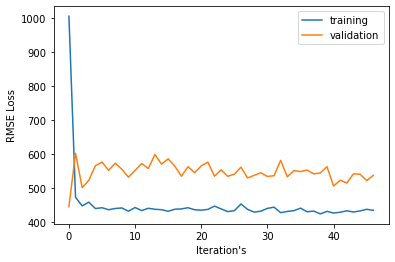

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rmse_loss, label="training")
plt.plot(valid_loss, label="validation")
plt.xlabel("Iteration's")
plt.ylabel("RMSE Loss")
plt.legend()
plt.show()

In [14]:
torch.sqrt(validate()).item()

508.0405578613281

In [15]:
model.eval()
with torch.no_grad():
    test = torch.from_numpy(np.loadtxt("../data/embed_testvf.csv", skiprows=1, dtype=np.float32, delimiter=",")).to(device)
    out = model(test)


In [16]:
print(out)

tensor([[  595.1992],
        [  481.4519],
        [  503.8652],
        [  516.5054],
        [  483.1253],
        [  449.2710],
        [  501.9019],
        [  563.2676],
        [  491.9269],
        [  513.7612],
        [  495.0778],
        [  515.0652],
        [  582.3671],
        [  786.9874],
        [  495.2583],
        [  672.3882],
        [  604.8181],
        [  829.1578],
        [  561.3132],
        [  589.0206],
        [  470.7342],
        [  516.1517],
        [  357.7119],
        [  771.2283],
        [  463.6952],
        [  765.3706],
        [  502.5200],
        [  493.2202],
        [  487.5332],
        [  513.8613],
        [  524.6701],
        [  526.9084],
        [  523.0247],
        [  598.2922],
        [  732.7845],
        [  490.8768],
        [  583.6222],
        [  435.1229],
        [  503.9504],
        [  521.0700],
        [  555.7860],
        [  455.8601],
        [  690.2720],
        [  632.6428],
        [  519.6885],
        [ 